<a href="https://colab.research.google.com/github/100jy/voice_competition/blob/master/%EB%8D%B0%EC%9D%B4%ED%84%B0_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA 및 방향 잡기


## MFCC를 통한 확인


In [ ]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# 모듈 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
import librosa
import librosa.display

In [ ]:
data = pd.read_pickle('drive/My Drive/data/x_trian_mfcc_80.pickle')
data = data.values

In [ ]:
label =pd.read_csv('drive/My Drive/data/train_answer.csv',index_col=0)

## 확률값 0.25의 배수가 아닌 경우 확인

In [ ]:
# 전부 0.25의 배수인 걸로 확인....
label_sum = np.max(label, axis = 0)
label_sum

bed       1.00
bird      0.75
cat       0.75
dog       0.75
down      0.75
eight     0.75
five      1.00
four      0.75
go        0.75
happy     0.75
house     0.75
left      1.00
marvin    0.75
nine      0.75
no        0.75
off       0.75
on        0.75
one       0.75
right     0.75
seven     0.75
sheila    0.75
six       1.00
stop      0.75
three     0.75
tree      0.75
two       1.00
up        0.75
wow       0.75
yes       1.00
zero      0.75
dtype: float64

중복 데이터 확인

In [ ]:
duplicated_label =  label[label['yes']==1].index 

In [ ]:
data = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
data = data.values

완전히 중복되는 경우는 없다...

In [ ]:
dupl_mfcc =  data[duplicated_label]

In [ ]:
idx = duplicated_label 
labels = []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  labels.append(string)

In [ ]:
idx

Int64Index([50417, 57376, 65940, 66780, 82290, 83730, 91418], dtype='int64', name='id')

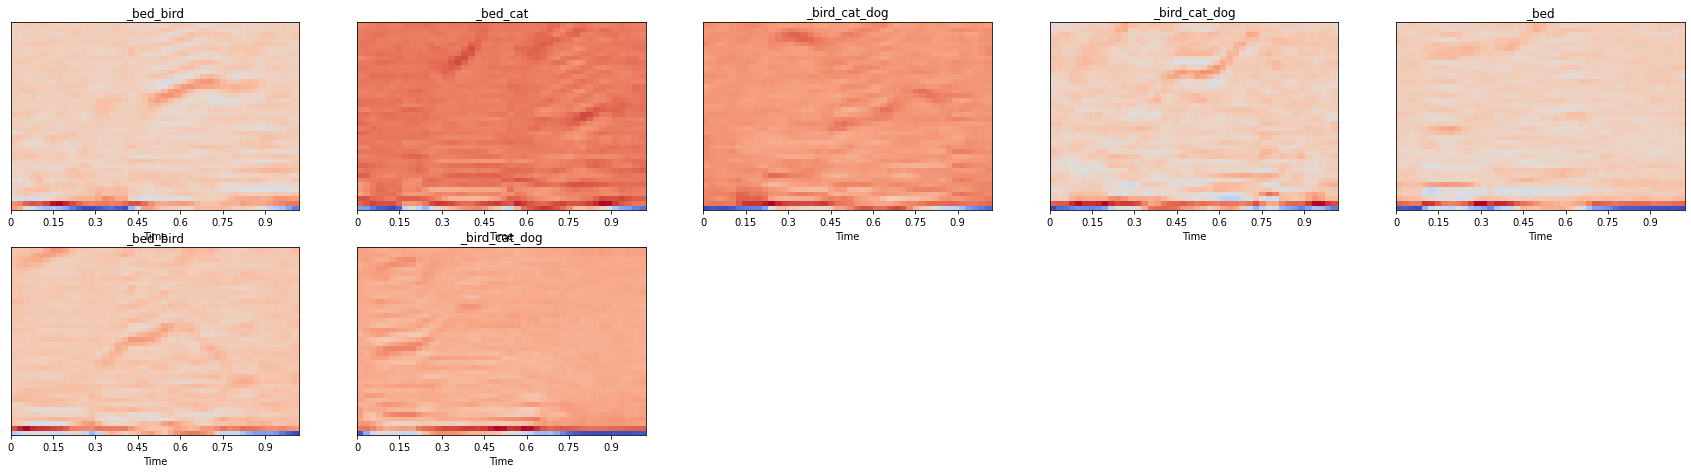

In [ ]:
plt.figure(figsize=(30,20))
for i,j in enumerate(duplicated_label):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = data[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

ValueError: ignored

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

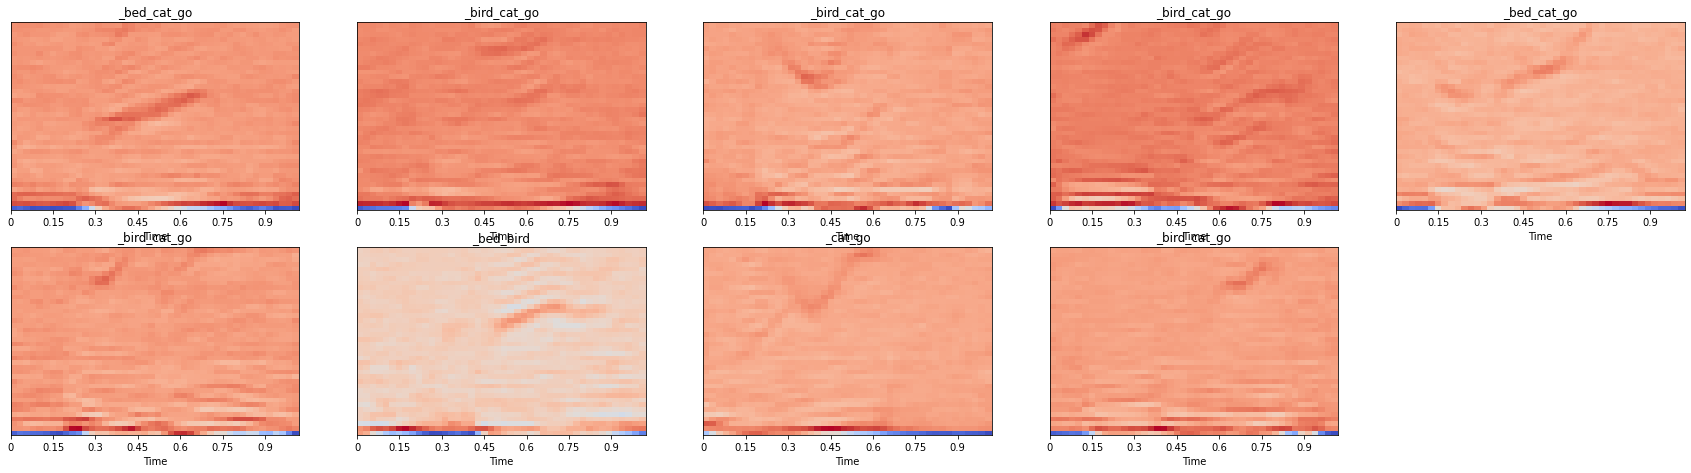

In [ ]:
duplicated_label =  label[label['bed']+label['bird']+label['cat']+label['go']==1].index 
dupl_mfcc =  data[duplicated_label]
idx = duplicated_label 
labels = []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  labels.append(string)
  plt.figure(figsize=(30,20))
for i,j in enumerate(duplicated_label):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = data[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

In [ ]:
mfcc.max()

107.10750926812531

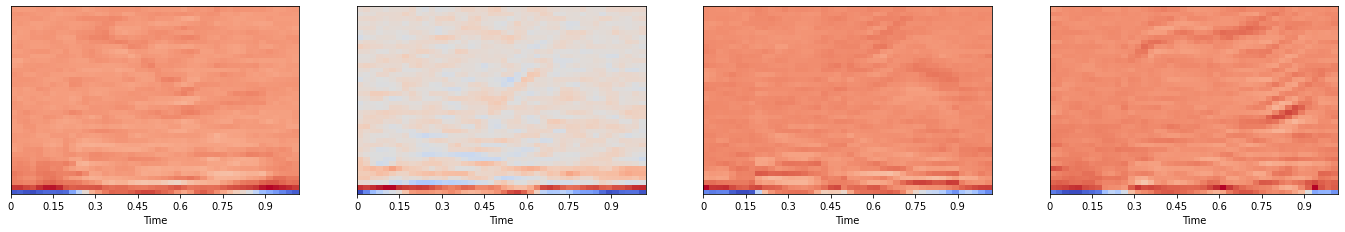

In [ ]:
plt.figure(figsize=(30,20))
for i,j in enumerate([1,100,200,500]):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = data[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  #plt.title(labels[i])

## 단어하나만 분리????

In [ ]:
label.columns

Index(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
       'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up',
       'wow', 'yes', 'zero'],
      dtype='object')

In [ ]:
bed_idx = label[label['bed']!=0].index[:100]

In [ ]:
data = pd.read_pickle('drive/My Drive/data/x_trian.pickle')
data = data.values

In [ ]:
sum_bed = np.array(np.sum(data[bed_idx],axis =0),dtype='int16')

In [ ]:
nor_bed = np.array((sum_bed/len(bed_idx)),dtype='int16')

In [ ]:
nor_bed

array([ 196, -316,  326, ...,  177,   65,   46], dtype=int16)

In [ ]:
test = data[bed_idx[0]]

In [ ]:
test

array([-2075, -4894, -5639, ...,  3687,  3578,  3318], dtype=int16)

In [ ]:
!pip install playsound

In [ ]:
from scipy.io.wavfile import *
wavfile.write('./bed.wav', 16000,nor_bed)
wavfile.write('./bed_sum.wav', 16000,sum_bed)

In [ ]:
nor_bed.shape

(16000,)

In [ ]:
test.shape

(16000,)

In [ ]:
from scipy.io.wavfile import *
wavfile.write('./nor_bed.wav', 16000,sum_bed)

실패.......

In [ ]:
idx = [0,2000,4000,8000,10000]
labels = []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  labels.append(string)

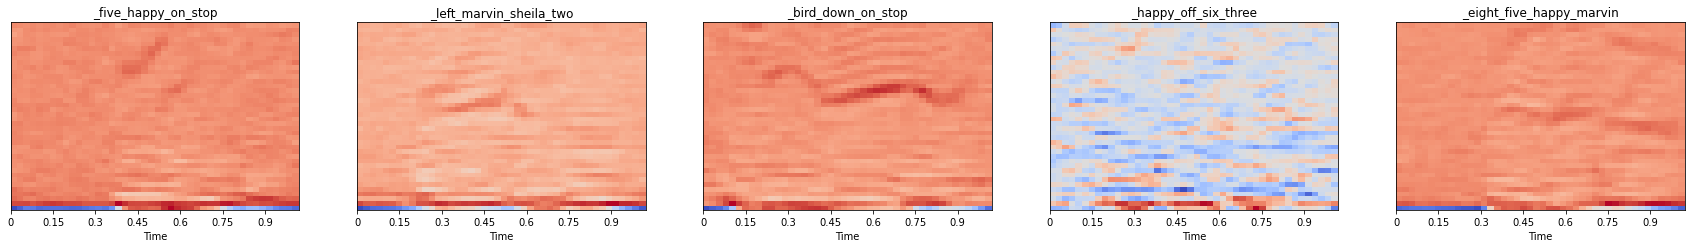

In [ ]:
plt.figure(figsize=(30,20))
for i,j in enumerate(idx):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = data[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

발화하는 단어에 따라 MFCC가 확실히 구분이 간다...

## scale 이후 변화 확인


In [ ]:
data = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
data = data.values

In [ ]:
x_scale = list((map(lambda x : x / max(abs(x)),data)))

In [ ]:
idx = [0,2000,4000,8000,10000]
labels = []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  labels.append(string)

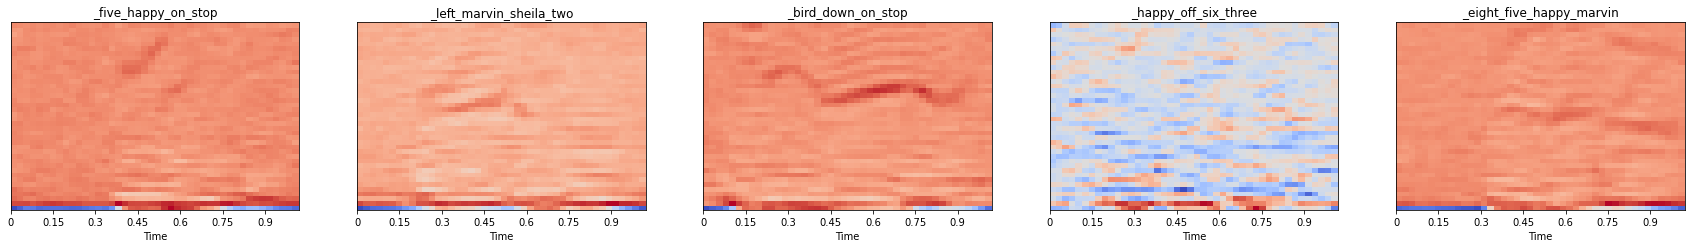

In [ ]:
plt.figure(figsize=(30,20))
for i,j in enumerate(idx):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  mfcc = x_scale[j].reshape(40,-1)
  librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

scale후에도 정보의 손실 거의 없다...


# augmentation을 통한 성능향상

In [ ]:
#noising
def noising(data,noise_factor):
  noise = np.random.rand(len(data)) * noise_factor 
  augmented = data + noise
  return augmented

# shifting
def shifting(data,direc):
  result  = np.zeros_like(data)
  k = int(np.random.randint(1,3) * (len(data)/15))
  #right
  if direc == '0':
    result[k:] = data[:len(data)-k]
  else:
    result[:len(data)-k] = data[k:]
  return result

#pith를 조절
def change_pitch(data,sr,k):
  return librosa.effects.pitch_shift(data,sr, k)

In [ ]:
data_11kH = pd.read_pickle('drive/My Drive/data/x_trian_sr_11025.pickle')
data_11kH = data_11kH.values

In [ ]:
data_MFCC = pd.read_pickle('drive/My Drive/data/x_trian_MFCC.pickle')
data_MFCC = data_MFCC.values

In [ ]:
noise_fac = 0.05
data_noise = noising(data_11kH[0],noise_fac)
data_shifted = shifting(data_11kH[0],0)
pitch_factor = np.random.rand(1)
data_pitch = change_pitch(data_11kH[0],11025, pitch_factor)

In [ ]:
aug_data = [data_MFCC[0],data_11kH[0],data_noise,data_shifted,data_pitch]
labels = ['original_22kh','original_11kh','+noise','shifted','changed_pitch']

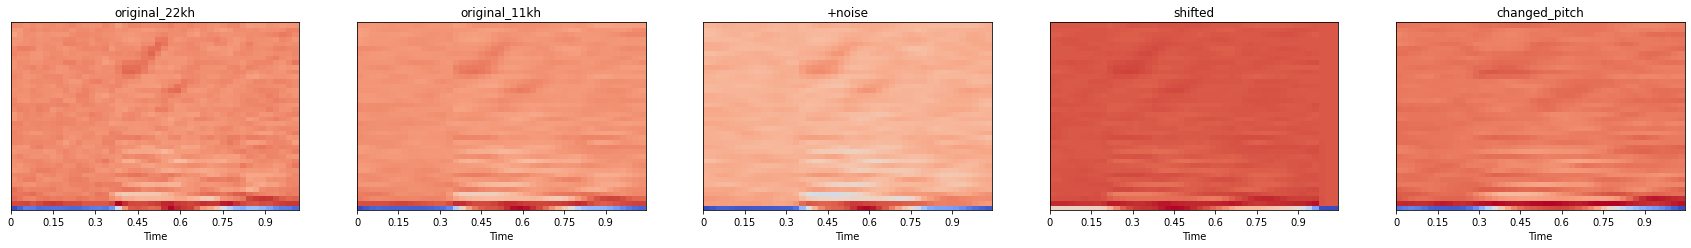

In [ ]:
plt.figure(figsize=(30,20))
for i,data in enumerate(aug_data):
  s = '55'+str(i+1)
  plt.subplot(int(s))
  if i == 0:
    mfcc = data.reshape(40,-1)
    librosa.display.specshow(mfcc, x_axis='time')
  else:
    mfcc = librosa.feature.mfcc(data,sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
    librosa.display.specshow(mfcc, x_axis='time')
  plt.title(labels[i])

In [ ]:
idx = [0,10,100,1000,5000]
true= []
for i in idx:
  tmp = list(label.columns[label.iloc[i,:] != 0])
  string = ''
  for j in tmp: 
    string += '_'+j
  true.append(string)

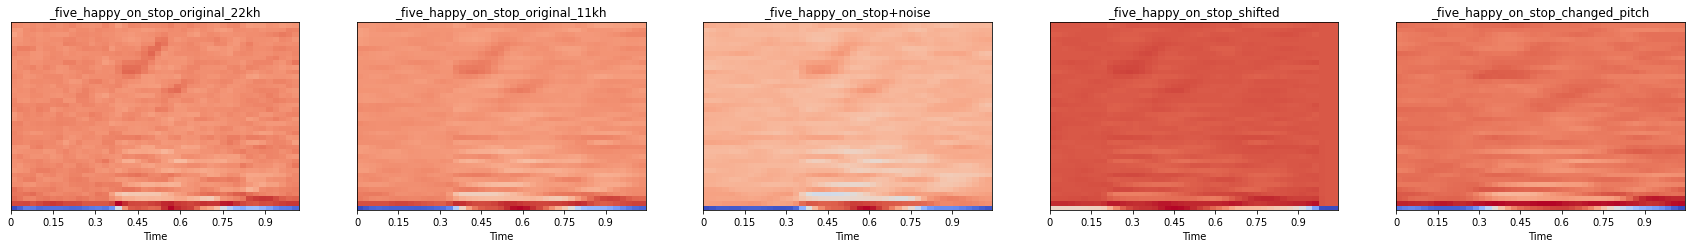

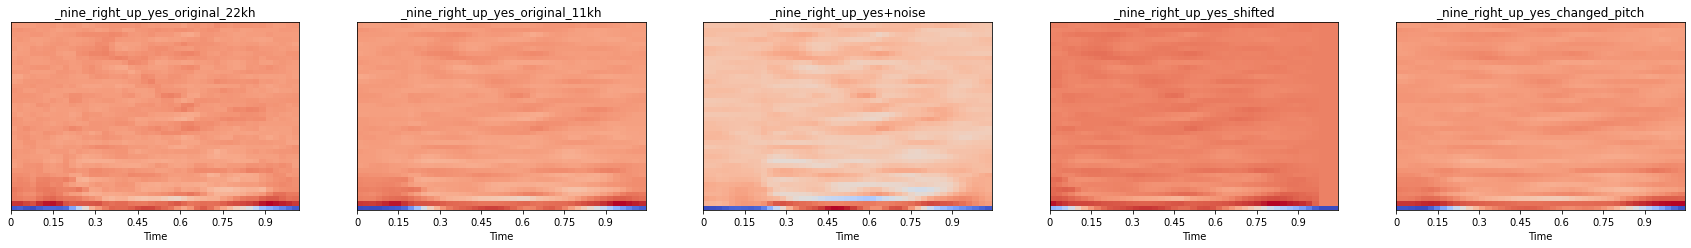

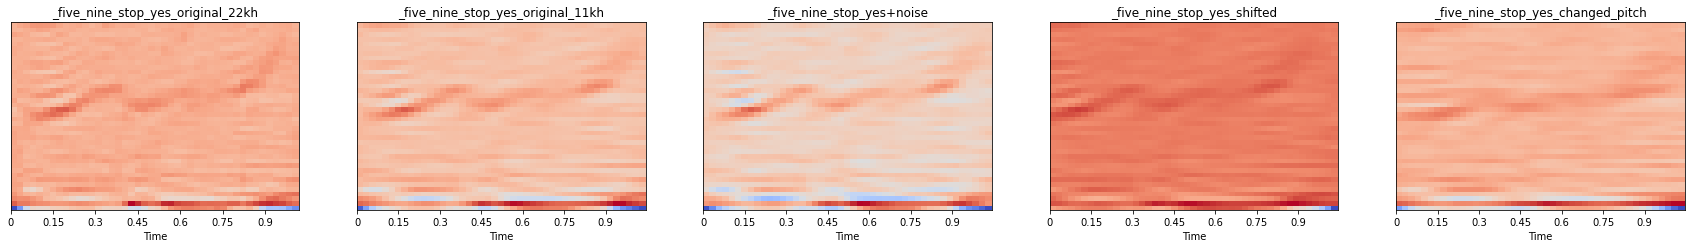

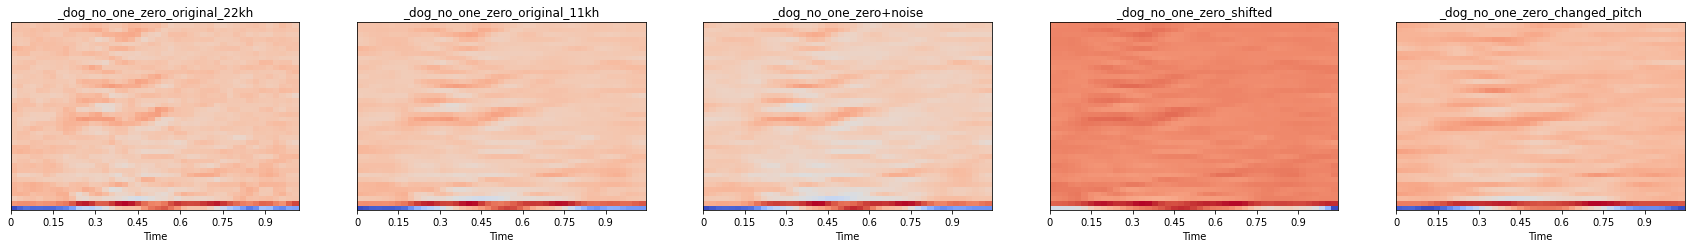

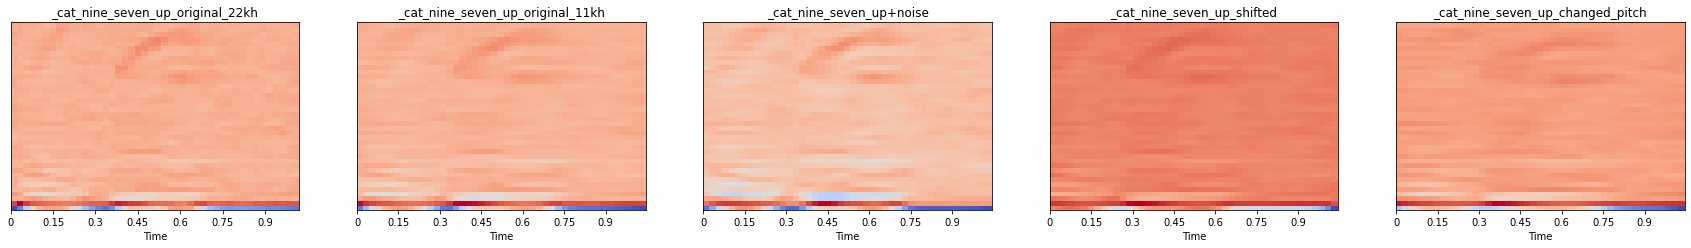

In [ ]:
for k in range(5):

  noise_fac = 0.05
  data_noise = noising(data_11kH[k],noise_fac)
  data_shifted = shifting(data_11kH[k],0)
  pitch_factor = np.random.rand(1)
  data_pitch = change_pitch(data_11kH[k],11025, pitch_factor)

  aug_data = [data_MFCC[k],data_11kH[k],data_noise,data_shifted,data_pitch]
  labels = [true[k]+'_original_22kh',true[k]+'_original_11kh',true[k]+'+noise',true[k]+'_shifted',true[k]+'_changed_pitch']
  plt.figure(figsize=(30,20))

  for i,data in enumerate(aug_data):
    s = '55'+str(i+1)
    plt.subplot(int(s))
    if i == 0:
      mfcc = data.reshape(40,-1)
      librosa.display.specshow(mfcc, x_axis='time',sr = 22050)
    else:
      #output length = (seconds) * (sample rate) / (hop_length)
      mfcc = librosa.feature.mfcc(data,sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
      librosa.display.specshow(mfcc, x_axis='time',sr = 22050)
    plt.title(labels[i])

22khz 샘플링 보다 11kh 샘플링이 더 선명하지 못하지만 두개가 같다고 인식할 정도는 된다. 마찬가지로 피치조절과 노이즈 추가 좌우 이동의 경우도 같은 형태를 가지고 있다.


# 데이터 보충

In [ ]:
def augmentation(data):
  new_data = []
  from tqdm.notebook import tqdm
  for i,cont in enumerate(tqdm(data)):
    #noise
    if i%3 == 0:
      noise_fac = 0.05
      noise = librosa.feature.mfcc(noising(cont,noise_fac),sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
      new_data.append(noise.flatten())
    #shifting
    elif i%3 == 1:
      direc = np.random.randint(0,1)
      shifted = librosa.feature.mfcc(shifting(cont,direc),sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
      new_data.append(shifted.flatten())
    #pitch_change
    else:
      pitch_factor = np.random.rand(1)
      pitch = librosa.feature.mfcc(change_pitch(cont,11025,pitch_factor),sr = 11025, n_mfcc=40, fmax=3000, hop_length = int(11025/44))
      new_data.append(pitch.flatten())

  return pd.DataFrame(new_data)

In [ ]:
new_data  = augmentation(data_11kH)
new_data.to_pickle('drive/My Drive/data/x_trian_augmented_mfcc.pickle')

# test set data 확인

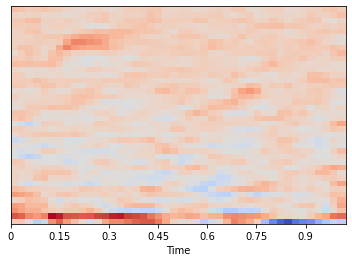

In [ ]:
data = pd.read_pickle('drive/My Drive/data/x_test_normalized.pickle').values
mfcc = data[0].reshape(40,-1)
librosa.display.specshow(mfcc, x_axis='time',sr = 22050)

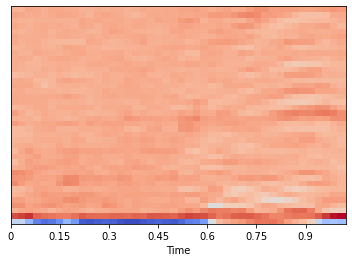

In [ ]:
data = pd.read_pickle('drive/My Drive/data/x_test_MFCC.pickle').values
# (0,1)로 정규화
data = list((map(lambda x : x / max(x),data)))
data =  np.array(data)
mfcc = data[0].reshape(40,-1)
librosa.display.specshow(mfcc, x_axis='time',sr = 22050)

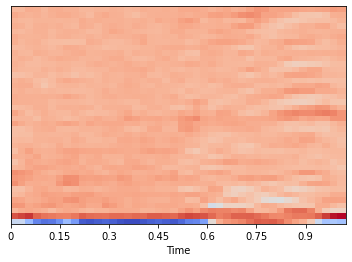

In [ ]:
# 잘못됬음ㅜㅜㅜㅜ
x,sr = librosa.load('drive/My Drive/data/test/test_00000.wav')
x = x / max(x) 
mfcc = librosa.feature.mfcc(x,sr = 22050, n_mfcc=40, fmax=3000)
librosa.display.specshow(mfcc, x_axis='time',sr = 22050)

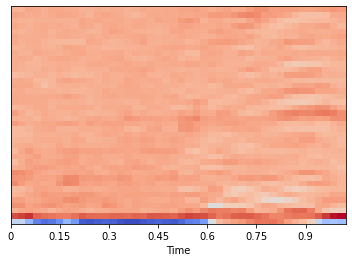

In [ ]:
x,sr = librosa.load('drive/My Drive/data/test/test_00000.wav')
mfcc = librosa.feature.mfcc(x,sr = 22050, n_mfcc=40, fmax=3000)
mfcc = mfcc.flatten()
mfcc = mfcc/ max(mfcc)
mfcc = mfcc.reshape(40,-1)
librosa.display.specshow(mfcc, x_axis='time',sr = 22050)

# MFCC parameter에 따른 변화 관찰

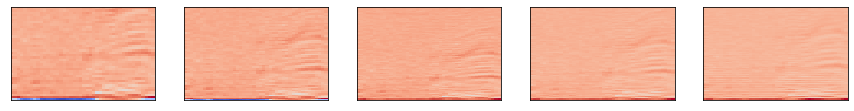

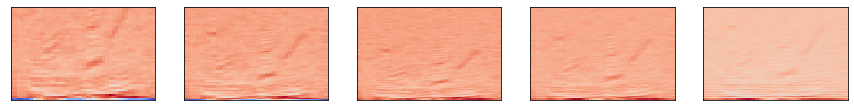

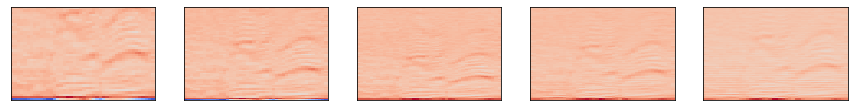

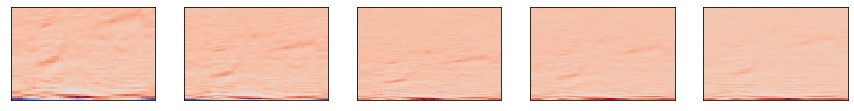

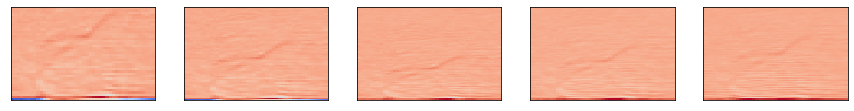

In [ ]:
for j in range(5):
  x,sr = librosa.load('drive/My Drive/data/test/test_0000{}.wav'.format(j))
  #n_mfcc = 40, fmax = 3000
  mfcc_1 = librosa.feature.mfcc(x,sr = 22050, n_mfcc=40, fmax=3000)
  #n_mfcc = 60, fmax = 3000
  mfcc_2 = librosa.feature.mfcc(x,sr = 22050, n_mfcc=60, fmax=3000)
  #n_mfcc = 80, fmax = 3000
  mfcc_3 = librosa.feature.mfcc(x,sr = 22050, n_mfcc=80, fmax=3000)
  #n_mfcc = 80, fmax = 5000
  mfcc_4 = librosa.feature.mfcc(x,sr = 22050, n_mfcc=80, fmax=5000)
  #n_mfcc = 80, fmax = 8000
  mfcc_5 = librosa.feature.mfcc(x,sr = 22050, n_mfcc=80, fmax=8000)

  mfcc = [mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5]

  plt.figure(figsize=(15,10))

  for i in range(5):
    st = '55'+str(i+1)
    plt.subplot(st)
    librosa.display.specshow(mfcc[i])
  

((80, 44), (80, 80))

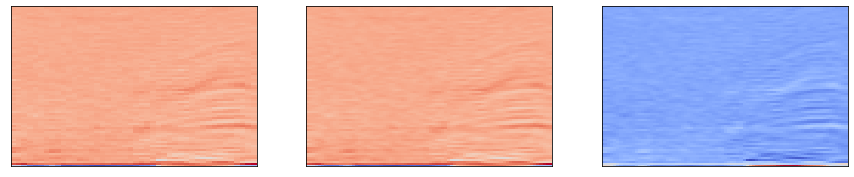

In [ ]:
# 80x80으로 뽑아보기, log변환에 따른 차이보기
## normalize 해보기
x,sr = librosa.load('drive/My Drive/data/test/test_00000.wav')

def normalize(x):
  return (x - np.mean(x)) / np.std(x)

epsilon = 1e-10
hop_size = int(sr/79)
mfcc_original = librosa.feature.mfcc(x,sr = 22050, n_mfcc=80, fmax=3000)
#80*80
mfcc_square = librosa.feature.mfcc(x,sr = 22050, n_mfcc=80, hop_length = hop_size ,fmax=3000)
mfcc_nor = librosa.feature.mfcc(normalize(x),sr = 22050, n_mfcc=80,hop_length = hop_size, fmax=3000)
#mfcc_log = librosa.feature.mfcc(np.log(x + epsilon),sr = 22050, n_mfcc=80,hop_length = hop_size, fmax=3000)

#mfcc = [mfcc_original,mfcc_square,mfcc_nor,mfcc_log]
mfcc = [mfcc_original,mfcc_square,mfcc_nor]

plt.figure(figsize=(15,10))

for i in range(3):
  st = '33'+str(i+1)
  plt.subplot(st)
  librosa.display.specshow(mfcc[i])

mfcc_original.shape, mfcc_square.shape

((80, 80), (80, 80))

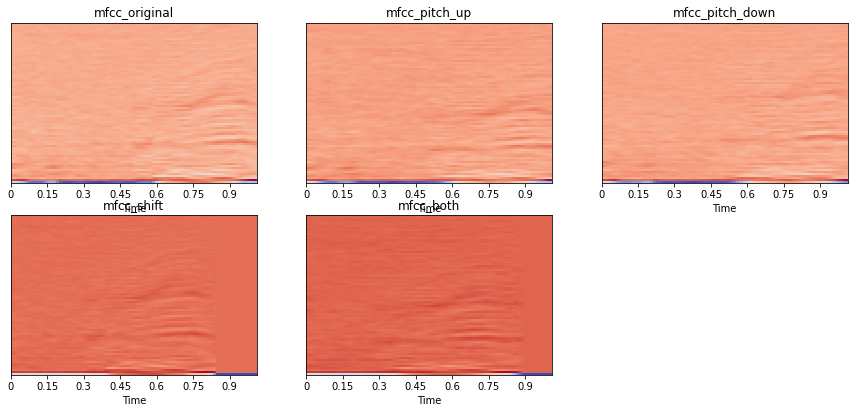

In [ ]:
#pitch change + shift

# shifting
def shifting(data,direc,factor):
  result  = np.zeros_like(data)
  k = int(factor * (len(data)/10))
  #right
  if direc == '0':
    result[k:] = data[:len(data)-k]
  else:
    result[:len(data)-k] = data[k:]
  return result

#pith를 조절
def change_pitch(data,sr,k):
  return librosa.effects.pitch_shift(data,sr, k)


x,sr = librosa.load('drive/My Drive/data/test/test_00000.wav')
hop_size = int(sr/79)
#
mfcc_original = librosa.feature.mfcc(x,sr = 22050, n_mfcc=80, hop_length = hop_size ,fmax=3000)
mfcc_pitch_up = librosa.feature.mfcc(change_pitch(x,sr,2),sr = 22050, n_mfcc=80, hop_length = hop_size ,fmax=3000)
mfcc_pitch_down = librosa.feature.mfcc(change_pitch(x,sr,-2),sr = 22050, n_mfcc=80, hop_length = hop_size ,fmax=3000)
mfcc_shift = librosa.feature.mfcc(shifting(x,0,2),sr = 22050, n_mfcc=80, hop_length = hop_size ,fmax=3000)
mfcc_both = librosa.feature.mfcc(change_pitch(shifting(x,0,2),sr,2),sr = 22050, n_mfcc=80, hop_length = hop_size ,fmax=3000)


mfcc = [mfcc_original,mfcc_pitch_up,mfcc_pitch_down,mfcc_shift,mfcc_both]
title = ['mfcc_original','mfcc_pitch_up','mfcc_pitch_down','mfcc_shift','mfcc_both']

plt.figure(figsize=(15,10))

for i in range(5):
  st = '33'+str(i+1)
  plt.subplot(st)
  librosa.display.specshow(mfcc[i],x_axis='time',hop_length = hop_size)
  
  plt.title(title[i])

In [ ]:
from scipy.io.wavfile import *
wavfile.write('./pitch.wav', 22050,change_pitch(x,sr,2))
wavfile.write('./pitch_down.wav', 22050,change_pitch(x,sr,-2))
wavfile.write('./original.wav', 22050,x)
wavfile.write('./shift.wav', 22050,shifting(x,0,2))

((80, 80), (128, 128))

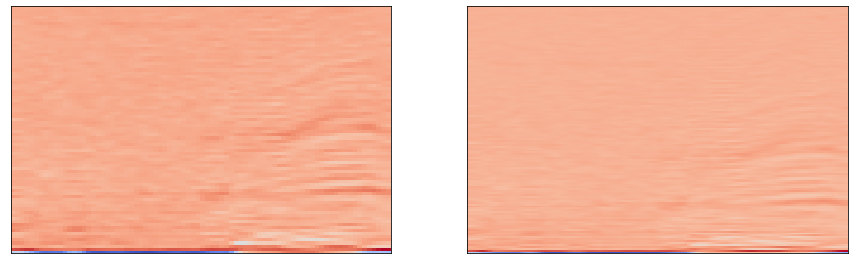

In [ ]:
#큰 이미지로 보면??
x,sr = librosa.load('drive/My Drive/data/test/test_00000.wav')
hop_size = int(sr/79)
#80*80
mfcc_80 = librosa.feature.mfcc(x,sr = 22050, n_mfcc=80, hop_length = hop_size ,fmax=3000)
#128*128
mfcc_160 = librosa.feature.mfcc(x,sr = 22050, n_mfcc=128 ,hop_length = int(hop_size*(79/127)), fmax=6000)

mfcc = [mfcc_80,mfcc_160]

plt.figure(figsize=(15,10))

for i in range(2):
  st = '22'+str(i+1)
  plt.subplot(st)
  librosa.display.specshow(mfcc[i])

mfcc_80.shape, mfcc_160.shape

fmax = 3000, n_mfcc = 80 이 가장 적절해보임....

nomalize한것과 2ch로 쓰는 게 좋을지???

80*80으로 학습... 


- augmentaion -> 일반화 성능 올릴 수 있지 않을까???
- 결과물 깔끔하게 구간화하는 방법...